## CSC 578 HW\#7 Intel Image Classification Competition (Spring 2024)

### Name: Michael DeCero
### 5/30/2024

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Load the training data. Split into training 80% and validation 20%.

In [2]:
train_directory = '../HW7/train'
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',        # use names of subdirectories as target labels
    label_mode='categorical', # convert target class (int) to one-hot-vector
    validation_split=0.2,
    subset="training",
    seed=123,                 # use same random seed with valid_set
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(150, 150),
)

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=123,
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(150, 150),
)

Found 13986 files belonging to 6 classes.
Using 11189 files for training.
Found 13986 files belonging to 6 classes.
Using 2797 files for validation.


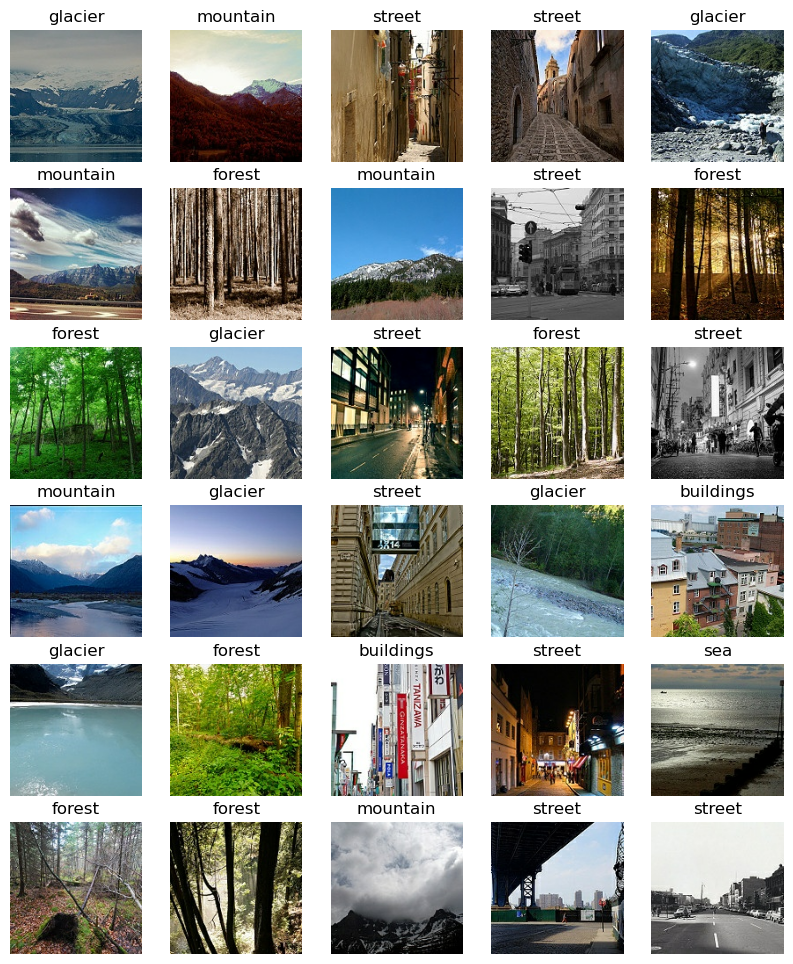

In [16]:
# Visualize some training examples.
plt.figure(figsize=(10, 12))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(1):
    for i in range(30):
        ax = plt.subplot(6, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

## Best model

In [17]:
# Model Architecture
model = keras.Sequential([
    keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Conv2D(256, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(6, activation='softmax')
])

# Optimizer and Compilation
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Print model summary to ensure
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 148, 148, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 72, 72, 64)      

In [19]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [20]:
# Fit the model
history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset, callbacks=[early_stopping])

Epoch 1/50
350/350 [==============================] - 225s 640ms/step - loss: 0.9733 - accuracy: 0.6497 - val_loss: 2.7771 - val_accuracy: 0.3114
Epoch 2/50
350/350 [==============================] - 210s 598ms/step - loss: 0.5775 - accuracy: 0.7880 - val_loss: 0.6353 - val_accuracy: 0.7701
Epoch 3/50
350/350 [==============================] - 217s 620ms/step - loss: 0.4161 - accuracy: 0.8503 - val_loss: 0.5868 - val_accuracy: 0.8030
Epoch 4/50
350/350 [==============================] - 211s 601ms/step - loss: 0.2942 - accuracy: 0.8937 - val_loss: 0.6198 - val_accuracy: 0.8037
Epoch 5/50
350/350 [==============================] - 216s 617ms/step - loss: 0.1900 - accuracy: 0.9337 - val_loss: 0.6268 - val_accuracy: 0.8130
Epoch 6/50
350/350 [==============================] - 215s 613ms/step - loss: 0.1408 - accuracy: 0.9518 - val_loss: 0.6822 - val_accuracy: 0.8094
Epoch 7/50
350/350 [==============================] - 211s 604ms/step - loss: 0.0982 - accuracy: 0.9678 - val_loss: 0.6597 -

### Visualize Training (accuracy and loss)

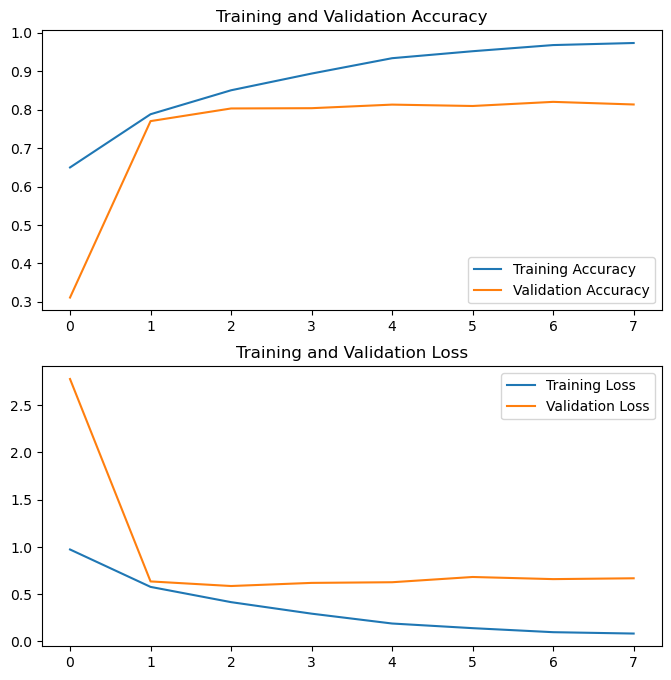

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Examine the results for some validation examples.

1/1 [==============================] - 0s 24ms/step


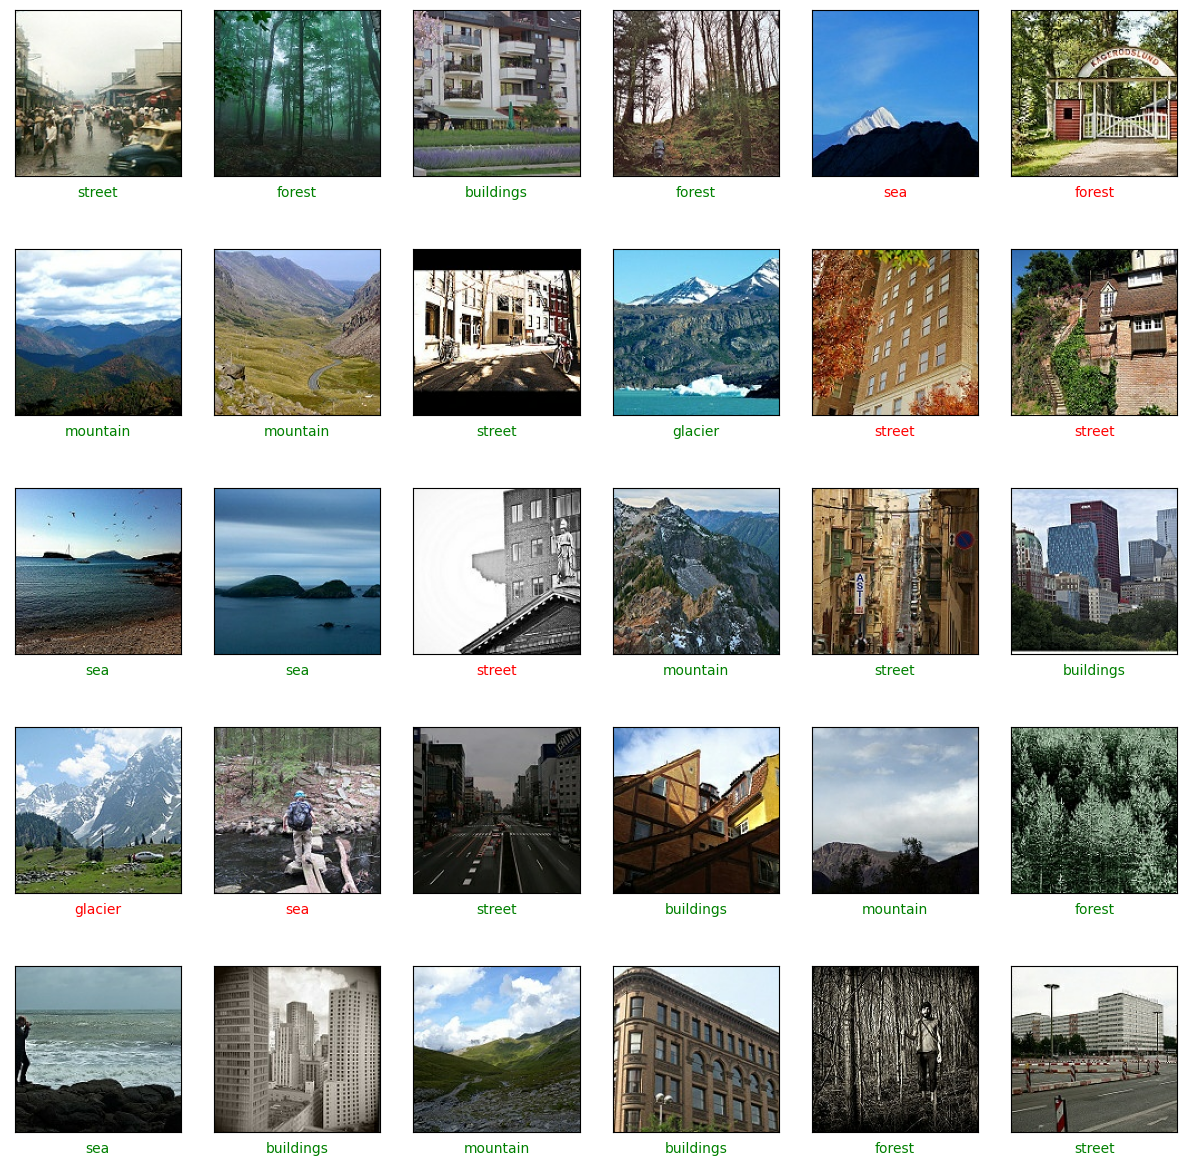

In [22]:
#Visualize 30 of the predicted data with green label for correct predictions
#and red label vise versa.
plt.figure(figsize=(15,15))
for images, labels in valid_dataset.take(1):
    for i in range(30):
        prediction = model.predict(images[i].numpy().reshape(1,150,150,3))
        plt.subplot(5, 6, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.grid(False)
        xlabel = plt.xlabel(class_names[prediction.argmax()])
        if (prediction.argmax() == labels[i].numpy().argmax()):
            xlabel.set_color("green")
        else:
            xlabel.set_color("red")
plt.show()

### Make Predictions for Test_Pred data.  
#### Note: Results are stored in a dictionary, which is keyed by file numbers (as integers).

In [23]:
!pip install opencv-python
import cv2

In [24]:
# Load the test_pred data (which has no target labels)
import os

pred_directory = '../HW7/test_pred'
result_dict = {} # dictionary to store predictions (keyed by file number)

# iterate over files in that directory
for filename in os.listdir(pred_directory):
    f = os.path.join(pred_directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        fnum = int(filename[:-4]) # filename e.g. '103.jpg" -> 103
        img = cv2.imread(f)
        #img = img/255.0
        img = img.reshape(-1,150,150,3)
        pred = model.predict(img)
        result_dict[fnum] = pred[0]  # [0] because there is only one data
print (len(result_dict))

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step
2993


### Inspect dictionary

In [25]:
first_pair = next(iter(result_dict.items()))

# Print the first key-value pair
print(first_pair)

(20056, array([1.11253954e-04, 4.11817014e-01, 5.49617946e-01, 3.47584428e-04,
       1.38763746e-03, 3.67186069e-02], dtype=float32))


### Create prediction file

In [26]:
import csv

# Define the header
header = ['fnum', 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Write to CSV
with open('results_md.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(header)
    # Write the data
    for key, values in result_dict.items():
        # Prepend the key to the list of values
        row = [key] + list(map(lambda x: format(x, '.5f'), values))
        writer.writerow(row)

print("Data has been written to results_md.csv")


Data has been written to results_md.csv


## Worst model

### Data Augmentation

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_dataset = train_datagen.flow_from_directory(
    '../HW7/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 13986 images belonging to 6 classes.


In [15]:
# Model Architecture
model = keras.Sequential([
    keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Conv2D(256, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(6, activation='softmax')
])

# Optimizer and Compilation
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Print model summary to ensure
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 148, 148, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 72, 72, 64)      

In [17]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [18]:
# Fit the model
history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset, callbacks=[early_stopping])

Epoch 1/50
438/438 [==============================] - 242s 551ms/step - loss: 1.2057 - accuracy: 0.5505 - val_loss: 32.2532 - val_accuracy: 0.2531
Epoch 2/50
438/438 [==============================] - 242s 553ms/step - loss: 0.9708 - accuracy: 0.6315 - val_loss: 577.8399 - val_accuracy: 0.1916
Epoch 3/50
438/438 [==============================] - 263s 601ms/step - loss: 0.9000 - accuracy: 0.6616 - val_loss: 816.4486 - val_accuracy: 0.1823
Epoch 4/50
438/438 [==============================] - 260s 593ms/step - loss: 0.8422 - accuracy: 0.6858 - val_loss: 536.9802 - val_accuracy: 0.1916
Epoch 5/50
438/438 [==============================] - 261s 595ms/step - loss: 0.7885 - accuracy: 0.7082 - val_loss: 1032.1138 - val_accuracy: 0.2088
Epoch 6/50
438/438 [==============================] - 261s 595ms/step - loss: 0.7522 - accuracy: 0.7266 - val_loss: 673.3198 - val_accuracy: 0.2302


### Visualize Training (accuracy and loss)

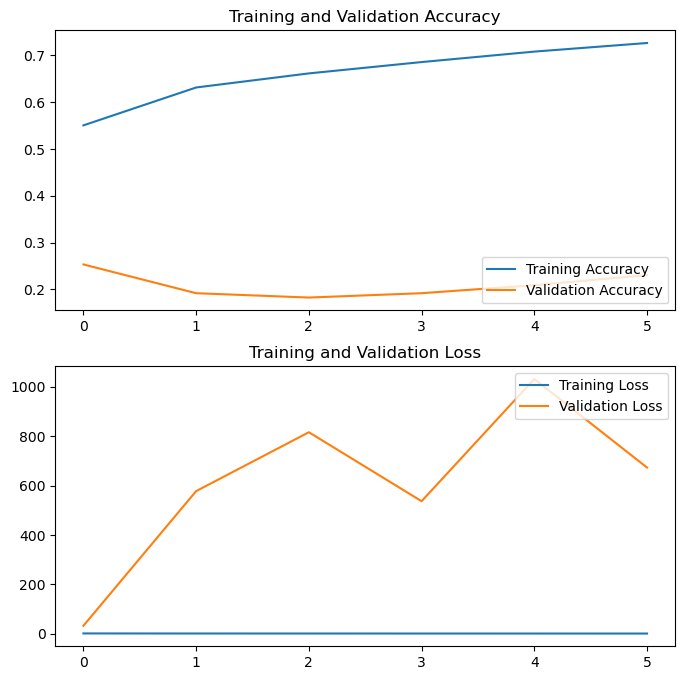

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Make Predictions for Test_Pred data.  
#### Note: Results are stored in a dictionary, which is keyed by file numbers (as integers).

In [20]:
!pip install opencv-python
import cv2

In [21]:
# Load the test_pred data (which has no target labels)
import os

pred_directory = '../HW7/test_pred'
result_dict = {} # dictionary to store predictions (keyed by file number)

# iterate over files in that directory
for filename in os.listdir(pred_directory):
    f = os.path.join(pred_directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        fnum = int(filename[:-4]) # filename e.g. '103.jpg" -> 103
        img = cv2.imread(f)
        #img = img/255.0
        img = img.reshape(-1,150,150,3)
        pred = model.predict(img)
        result_dict[fnum] = pred[0]  # [0] because there is only one data
print (len(result_dict))

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step
2993


### Inspect dictionary

In [22]:
first_pair = next(iter(result_dict.items()))

# Print the first key-value pair
print(first_pair)

(20056, array([4.9808738e-01, 3.7553541e-08, 2.8687477e-17, 1.9506520e-10,
       1.8169455e-14, 5.0191253e-01], dtype=float32))


### Create prediction file

In [23]:
import csv

# Define the header
header = ['fnum', 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Write to CSV
with open('results_md.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(header)
    # Write the data
    for key, values in result_dict.items():
        # Prepend the key to the list of values
        row = [key] + list(map(lambda x: format(x, '.5f'), values))
        writer.writerow(row)

print("Data has been written to results_md.csv")


Data has been written to results_md.csv
